In [1]:
from keras.layers import LSTM,Embedding,Dense,Input
from keras.models import  Model
from keras.optimizers import Adam,SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

C:\Users\risha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
MAX_SEQUENCE_LEN =100
MAX_VOCAB_LEN = 3000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
EPOCHS = 2000
BATCH_SIZE = 128
LATENT_DIM = 25

In [4]:
input_texts = []
target_texts = []
for line in open('robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue

    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)
    
all_lines = input_texts + target_texts

In [5]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_LEN,filters='')
tokenizer.fit_on_texts(all_lines)
ip_seq = tokenizer.texts_to_sequences(input_texts)
op_seq = tokenizer.texts_to_sequences(target_texts)

In [6]:
max_seq_len_from_data = max(len(s)for s in ip_seq)

In [7]:
max_seq_len_from_data

12

In [8]:
word2idx = tokenizer.word_index

In [9]:
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

In [10]:
len(word2idx)

3056

In [11]:
max_seq_len = min(max_seq_len_from_data,MAX_SEQUENCE_LEN)

In [12]:
max_seq_len

12

In [13]:
ip_seq = pad_sequences(ip_seq,maxlen=max_seq_len,padding='post')
op_seq = pad_sequences(ip_seq,maxlen = max_seq_len,padding = 'post')

In [14]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../all (1)/large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM),encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [15]:
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_LEN, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_LEN:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [16]:
one_hot_targets = np.zeros((len(ip_seq), max_seq_len, num_words))
for i, op_seq in enumerate(op_seq):
    for t, word in enumerate(op_seq):
        if word > 0:
            one_hot_targets[i, t, word] = 1

In [17]:
embd_layer = Embedding(num_words,EMBEDDING_DIM,weights = [embedding_matrix],trainable=False)

In [18]:
print('Building Model')

ip_ = Input(shape=(max_seq_len,))
init_h = Input(shape=(LATENT_DIM,))
init_c = Input(shape=(LATENT_DIM,))
x = embd_layer(ip_)
lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True)
x,_,_ = lstm(x,initial_state = [init_h,init_c])
dense = Dense(num_words,activation='softmax')
op = dense(x)

Building Model


In [19]:
model = Model([ip_,init_h,init_c],op)
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.01),metrics=['accuracy'])

In [20]:
z = np.zeros((len(ip_seq),LATENT_DIM))
r = model.fit([ip_seq,z,z],one_hot_targets,validation_split=VALIDATION_SPLIT,batch_size=BATCH_SIZE,
         epochs=100,verbose=1)

Train on 1148 samples, validate on 288 samples
Epoch 1/100
1148/1148 [==============================] - 12s 11ms/step - loss: 5.3758 - acc: 0.0021 - val_loss: 5.1006 - val_acc: 0.0014
Epoch 2/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.7712 - acc: 0.0146 - val_loss: 5.0241 - val_acc: 0.0220
Epoch 3/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.5608 - acc: 0.0333 - val_loss: 4.8725 - val_acc: 0.0226
Epoch 4/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.4209 - acc: 0.0703 - val_loss: 4.7381 - val_acc: 0.1059
Epoch 5/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.3066 - acc: 0.1168 - val_loss: 4.6222 - val_acc: 0.1059
Epoch 6/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.2041 - acc: 0.1167 - val_loss: 4.5244 - val_acc: 0.1059
Epoch 7/100
1148/1148 [==============================] - 9s 8ms/step - loss: 4.0820 - acc: 0.1167 - val_loss: 4.4123 - val_acc: 0.1073
Epoch 

Epoch 61/100
1148/1148 [==============================] - 9s 7ms/step - loss: 0.4485 - acc: 0.6307 - val_loss: 2.5262 - val_acc: 0.4925
Epoch 62/100
1148/1148 [==============================] - 10s 8ms/step - loss: 0.4402 - acc: 0.6331 - val_loss: 2.5278 - val_acc: 0.4925
Epoch 63/100
1148/1148 [==============================] - 9s 7ms/step - loss: 0.4325 - acc: 0.6340 - val_loss: 2.5324 - val_acc: 0.4945
Epoch 64/100
1148/1148 [==============================] - 8s 7ms/step - loss: 0.4245 - acc: 0.6337 - val_loss: 2.5387 - val_acc: 0.4931
Epoch 65/100
1148/1148 [==============================] - 8s 7ms/step - loss: 0.4165 - acc: 0.6352 - val_loss: 2.5456 - val_acc: 0.4931
Epoch 66/100
1148/1148 [==============================] - 8s 7ms/step - loss: 0.4090 - acc: 0.6370 - val_loss: 2.5501 - val_acc: 0.4919
Epoch 67/100
1148/1148 [==============================] - 8s 7ms/step - loss: 0.4016 - acc: 0.6373 - val_loss: 2.5545 - val_acc: 0.4931
Epoch 68/100
1148/1148 [=======================

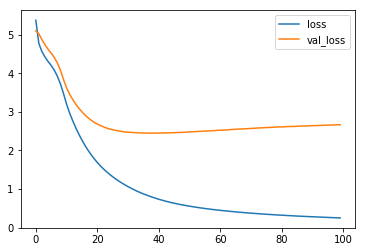

In [21]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [22]:
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embd_layer(input2)
x, h, c = lstm(x, initial_state=[init_h, init_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, init_h, init_c], [output2, h, c])

In [23]:
idx2word = {v:k for k, v in word2idx.items()}

In [24]:
def sample_line():
    # initial inputs
    np_input = np.array([[ word2idx['<sos>'] ]])
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))

    # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_seq_len):
        o, h, c = sampling_model.predict([np_input, h, c])

        # print("o.shape:", o.shape, o[0,0,:10])
        # idx = np.argmax(o[0,0])
        probs = o[0,0]
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        # accuulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [25]:
while True:
    for _ in range(4):
        print(sample_line())
    ans = input("---generate another? [Y/n]---")
    if ans and ans[0].lower().startswith('n'):
        break

<sos> it's poor, 'the she, let's dear, it's she, great, she, "ile's
<sos> 'you 'you i'm dear, everything, walls, great, ain't by by by
<sos> (we harmless. great, 'cross 'cross great, the' 'cross 'cross thence thence
<sos> stillgoing raining.' dear, dear, walls, walls, aren't great, granny, shouldn't shrill
---generate another? [Y/n]---y
<sos> 'you've waiting.' there's walls, spectre. she, 'cross great, "ile's joe, dear,
<sos> 'i won't shouldn't important, great, granny, we're- important, great, movement movement
<sos> it's out!" shouldn't great, skeleton. great, 'cross great, 'cross tunnel tunnel
<sos> doesn't out!" she, 'the walls, great, walls, heart. let's 'the street
---generate another? [Y/n]---y
<sos> i've it's 'the let's great, you're sprung fault mars mars mars
<sos> don't raining.' 'as aren't great, she, 'the 'cross misting; important, important,
<sos> 'four so- dear, listen. speaking: great, let's great, important, "ile's said,
<sos> let's won't 'it great, it's barb ears ears